<a href="https://colab.research.google.com/github/Ogunfool/Prognostics-Strategies-An-Aero-engine-Use-case/blob/main/Unsupervised_Learning_Health_Index_Construction_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains different unsupervised learning models used for HI construction. It includes, PCA, Autoencoder and Convolutional autoencoder.
This work is still in progress, more sophisticated unsupervised HI construction models will are currently being worked upon.

Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.decomposition import PCA
import seaborn as sns

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras import losses, optimizers, layers, activations, regularizers
from keras.layers import Dense, Conv1D, LSTM, GRU, Input, Concatenate, MaxPool1D, Flatten, GlobalMaxPool1D
from keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy

In [ ]:
from tensorflow.keras.optimizers import Adam, RMSprop, Adagrad, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
# !pip install -q -U keras-tuner
import keras_tuner as kt

In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [ ]:
# Next, we'll confirm that we can connect to the GPU with tensorflow:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Helper Functions

In [ ]:
np.set_printoptions(suppress=True, linewidth=100, precision=2)

In [ ]:
# Checkpoints - List and npy files
# np.save() - Saves a single array in a binary numpy format
def checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data)
  checkpoint_variable = np.load(filename + '.npy') #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

# List Checkpoint
def list_checkpoints(filename, checkpoint_data):
  np.save(filename, checkpoint_data, allow_pickle=True)
  checkpoint_variable = np.load(filename + '.npy', allow_pickle=True) #Load so that we always have an on-hand version of the checkpoint
  return(checkpoint_variable)

Load Data

In [ ]:
from google.colab import files
uploaded = files.upload()

Selected Feature Matrix (x_train and x_val) and Original health indices (y_train and y_val).

In [ ]:
x_train = np.load('/content/x-train.npy')
y_train = np.load('/content/y-train.npy')
x_val = np.load('/content/x-val.npy')
y_val = np.load('/content/y-val.npy')

3D Data conversion of the selected feature matrix - "See HI prediction models" for how data is prepared. 

In [ ]:
NTD_x_train = np.load('/content/NTD-X-train.npy')
NTD_x_val = np.load('/content/NTD-X-val.npy')

Master dataframe that contains all HI's from different models up till now. 

In [ ]:
# Load HItrain and HIval back in
HItrain_df = pd.read_csv('/content/HItrain-df (1)')
HIval_df = pd.read_csv('/content/HIval-df (1)')

In [ ]:
HItrain_df.head()

In [ ]:
# Take median of the maxcycle of nearest residuals or neighbours
# Instances maxcycle_df
max_cycle_df = HItrain_df.groupby('Unit_id').max()['Time'].reset_index().rename(columns={'Time':'max_cycle'})
max_cycle_df.head()

In [ ]:
max_cycle_df.set_index('Unit_id',inplace=True)
max_cycle_df.head()

,max_cycle
Unit_id,
1,149
2,269
3,206
4,235
5,154


# Health index constructor with PCA.

Retain about 80% variance.

In [ ]:
from scipy.linalg import norm
# Reconstruction error
def reconsruction_error(original, reconstructed):
  return norm((original-reconstructed))

In [ ]:
# Sklearn PCA automatically does mean normalization but not standardization (i.e doesn't divide by std - determine if this is required for your dataset yourself)
pca = PCA()
pca.fit(x_train)
orig_transform = pca.transform(x_train)
orig_reconstruction = pca.inverse_transform(orig_transform)  # Transform back to original shape 
error_1 = reconsruction_error(original=x_train, reconstructed=orig_reconstruction)

In [ ]:
orig_transform.shape

(41456, 8)

In [ ]:
error_1

4.397569313483957e-13

In [ ]:
out_data_transform = pca.transform(x_val) # Use the n_components to transform validation data
out_data_reconstruction = pca.inverse_transform(out_data_transform)  # Transform back to original shape 
error_2 = reconsruction_error(original=x_val, reconstructed=out_data_reconstruction)

In [ ]:
out_data_transform.shape

(12303, 8)

In [ ]:
error_2

2.4550701580408806e-13

In [ ]:
# K components was chosen such that 99% of the variance was retained
print(pca.explained_variance_ratio_.round(2),pca.explained_variance_.round(2))

[0.55 0.22 0.06 0.06 0.05 0.03 0.03 0.01] [4.4  1.76 0.48 0.46 0.38 0.27 0.2  0.05]


In [ ]:
# Eigen Values
contr = pca.explained_variance_ratio_.round(2)

Let's create multi-dimensional PCA dataframes

In [ ]:
PCA_HItrain_df = HItrain_df[['Unit_id','Time','ori_HI','Maxcycle','RUL']]
PCA_HItrain_df.head()

In [ ]:
PCA_HIval_df = HIval_df[['Unit_id','Time','ori_HI','Maxcycle','RUL']]
PCA_HIval_df.head()

In [ ]:
PCA_HItrain_df.loc[:,('HI_PCA1','HI_PCA2','HI_PCA3')] = orig_transform[:,:3]
PCA_HItrain_df.head()

In [ ]:
PCA_HIval_df.loc[:,('HI_PCA1','HI_PCA2','HI_PCA3')] = out_data_transform[:,:3]
PCA_HIval_df.head()

,Unit_id,Time,ori_HI,Maxcycle,RUL,HI_PCA1,HI_PCA2,HI_PCA3
0,201,1,1.000000,191,190,-3.938672,0.349602,0.160232
1,201,2,0.994737,191,189,-2.332807,-0.573674,-0.667446
2,201,3,0.989474,191,188,-2.512478,-0.037324,-0.308155
3,201,4,0.984211,191,187,-2.180602,-0.386085,0.215751
4,201,5,0.978947,191,186,-3.277371,0.223124,-0.253054


PCA Fusion: Linear combination weighted by the percentage of contribution of the chosen principal components - Simply, dot product of the PCA elements (matrix) and the contribution (vector).

In [ ]:
# from 8 dim to 3 dim
HI_PCA_B = np.dot(orig_transform[:,:2], contr[:2])
HI_PCA_B.shape

(41456,)

In [ ]:
plt.plot(HI_PCA_B[:500]);

Feature scaling: Scale the HI to range [0-1] - z = x-min/max-min

In [ ]:
min_x = min(HI_PCA_B)
max_x = max(HI_PCA_B)
range = max_x - min_x
HI_z = (HI_PCA_B - min_x)/(range)

In [ ]:
HI_PCA_B

array([-0.84, -0.71, -0.51, ...,  2.77,  3.61,  3.59])

In [ ]:
HI_z

(41456,)

In [ ]:
arr_z = np.array([HI_PCA_B,HI_z]).T
arr_z.shape

(41456, 2)

In [ ]:
HItrain_df.loc[:,['HI_PCA_L','HI_PCA_Lz']] = arr_z
PCA_HItrain_df.loc[:,['HI_PCA_L','HI_PCA_Lz']] = arr_z
PCA_HItrain_df.head()

Validation data feature fusion.

In [ ]:
# from 8 dim to 3 dim
HI_PCA_B = np.dot(out_data_transform[:,:2], contr[:2])
HI_PCA_B.shape

(12303,)

In [ ]:
plt.plot(HI_PCA_B[:500]);

Feature scaling: Scale the HI to range [0-1] - z = x-min/max-min

In [ ]:
min_x = min(HI_PCA_B)
max_x = max(HI_PCA_B)
range = max_x - min_x
HI_z = (HI_PCA_B - min_x)/(range)

In [ ]:
arr_z = np.array([HI_PCA_B,HI_z]).T
arr_z.shape

(12303, 2)

In [ ]:
HIval_df.loc[:,['HI_PCA_L','HI_PCA_Lz']] = arr_z
PCA_HIval_df.loc[:,['HI_PCA_L','HI_PCA_Lz']] = arr_z
PCA_HIval_df.head()

,Unit_id,Time,ori_HI,Maxcycle,RUL,HI_PCA1,HI_PCA2,HI_PCA3,HI_PCA_L,HI_PCA_Lz
0,201,1,1.000000,191,190,-3.938672,0.349602,0.160232,-2.089357,0.013486
1,201,2,0.994737,191,189,-2.332807,-0.573674,-0.667446,-1.409252,0.090581
2,201,3,0.989474,191,188,-2.512478,-0.037324,-0.308155,-1.390074,0.092755
3,201,4,0.984211,191,187,-2.180602,-0.386085,0.215751,-1.284270,0.104748
4,201,5,0.978947,191,186,-3.277371,0.223124,-0.253054,-1.753467,0.051562


NOTE: After the HI construction for any model, the health indices are saved to a general dataframe (for train and validation data) named comp_df. This comp_df (meaning compiled HI dataframe) is used during testing with actual test set to choose the best model. 

# Health Index Construction with Autoencoders.

Train-val loss plot helper function.

In [ ]:
# Helper function that plots, saves and shows plots
def plot_loss_accuracy(filename):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.savefig(filename + '.png')
  plt.show()

Basic Autoencoder Training - Using Subclass Method.


*   This is the simplest autoencoder, you can simply think of it as PCA. We transform the input data (D=8) to latent space (D=3) then reconstruct it back to D=8.


In [ ]:
latent_dim = 3
K = 8

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Dense(5, activation='relu'),
      layers.Dense(3, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(5, activation='relu'),
      layers.Dense(K),  # I am not sure of the activation function thing
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
tf.keras.backend.clear_session()

early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = autoencoder.fit(x_train, x_train,
                epochs=60,
                shuffle=False,
                callbacks=[early_stopping],
                validation_data=(x_val, x_val))

In [ ]:
# Latent representation and reconstructed validation data
x_val_latent = autoencoder.encoder(x_val).numpy()
x_val_reconstructed = autoencoder.decoder(x_val_latent).numpy()

# Latent representation and reconstructed train data
x_train_latent = autoencoder.encoder(x_train).numpy()
x_train_reconstructed = autoencoder.decoder(x_train_latent).numpy()

In [ ]:
x_val_latent.shape

(12303, 3)

In [ ]:
from scipy.linalg import norm
# Reconstruction error - MSE
def reconstruction_error(original, reconstructed):
  return norm((original-reconstructed))

In [ ]:
# Reconstruction error
rec_error_train = reconstruction_error(x_train, x_train_reconstructed)
rec_error_val = reconstruction_error(x_val, x_val_reconstructed)

In [ ]:
rec_error_train

236.37072233379027

In [ ]:
r2_score(x_train, x_train_reconstructed)

0.8315348852500315

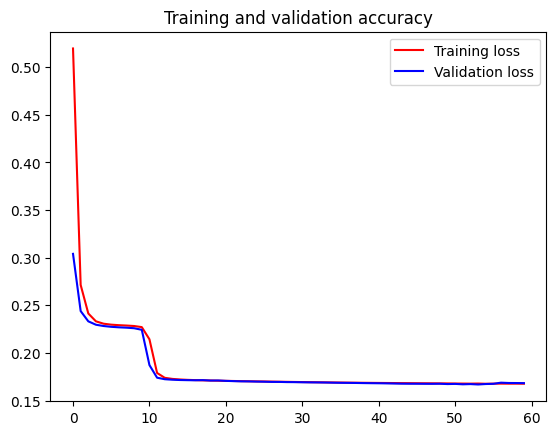

<Figure size 640x480 with 0 Axes>

In [ ]:
plot_loss_accuracy(filename='Autoencoder')

Model Evaluation: We should be focused on the the reconstruction error on the validation set to really have an idea of how well the model is behaving.In this example, the train and val losses are tight so we don't have the issue of overfitting. To quatify how much info is retained, we use the r2-score.

Let's create multi-dimensional AE dataframes.

In [ ]:
AE_HItrain_df = HItrain_df[['Unit_id','Time','ori_HI','Maxcycle','RUL']]
AE_HItrain_df.head()

In [ ]:
AE_HIval_df = HIval_df[['Unit_id','Time','ori_HI','Maxcycle','RUL']]
AE_HIval_df.head()

In [ ]:
AE_HItrain_df.loc[:,('HI_AE1','HI_AE2','HI_AE3')] = x_train_latent
AE_HItrain_df.head()

In [ ]:
AE_HIval_df.loc[:,('HI_AE1','HI_AE2','HI_AE3')] = x_val_latent
AE_HIval_df.head()

# Evaluation of above methods on validation set

In [ ]:
# This is the residual function we are using because the lent can be larger than some instance's maxcycles.....
def residual_func(train_df, test_df, lent, name):
  no_instances = train_df['Unit_id'].unique().shape[0]
  res_mat = np.zeros((lent, no_instances))
  cur_val = test_df[name][:lent]
  for id in train_df['Unit_id'].unique():
    # If it is already dead, then maybe you shouldn't be part of the computation OR add zeros below it
    temp_df = train_df[train_df['Unit_id']==id]
    if temp_df.shape[0] < lent:
      diff_arr = np.zeros(lent- temp_df.shape[0])
      cur_train = temp_df[name][:lent]
      cur_train = np.concatenate((cur_train, diff_arr), axis=0)
      res_mat[:,id-1] = cur_train
    else:
      temp_df = train_df[train_df['Unit_id']==id]
      cur_train = temp_df[name][:lent]
      res_mat[:,id-1] = cur_train

  l = res_mat - cur_val.to_numpy().reshape((-1,1))
  residual = np.sqrt(np.mean(l**2, axis=0))
  return residual

In [ ]:
def lenght(test_df, pct):
 lent = math.ceil(test_df.shape[0]*pct)
 return lent

def neighbors(residual,nearest):
  n_neighbors = np.argsort(residual)[:nearest]
  return n_neighbors

In [ ]:
#  The function for new data will be a little different from that of val data
def RUL_estimator(train_df, test_df, max_cycle_df, pct, nearest, name):
  # Call Lenght Function
  lent = lenght(test_df,pct)

  # Call Residual Function
  residual = residual_func(train_df, test_df, lent, name)

  # Nearest neighbours function - where you can change the size of nearest neighbours
  n_neighbors = neighbors(residual,nearest)

  # RUL Estimation
  # We want the closest 50 that are not yet dead
  ens_RULs = max_cycle_df.loc[n_neighbors+1] - lent

  true_RUL = test_df.shape[0] - lent

  m = ens_RULs[ens_RULs>-10]
  m[m.isna()] = 0

  est_RUL = m['max_cycle'].median()

  return (est_RUL, true_RUL, (ens_RULs))
  # return lent, residual, n_neighbors

In [ ]:
def RUL_Estimator_coll(train_df, test_df, max_cycle_df, nearest, name):
  # Instantiate pct list:
  pct_list = [0.5,0.7,0.9]
  # Val_data unique ID
  inst_id = test_df['Unit_id'].unique()

  # Create a results dictionary:
  val_inst = {}
  for i in inst_id:
    val_inst[i] = {}
    for j in [0.5, 0.7, 0.9]:
      val_inst[i][j] = (0,0,())

  # Loop through all val_instances
  for k in inst_id:
    # Working with a single test set:
    for pct in [0.5, 0.7, 0.9]: 
      cur_val_df = test_df[test_df['Unit_id'] == k]
      val_inst[k][pct] = RUL_estimator(train_df=train_df, test_df=cur_val_df, max_cycle_df=max_cycle_df, pct=pct, nearest=nearest, name=name)

  return val_inst


In [ ]:
def result_analysis(val_inst):
  fif = []
  sev = []
  nine = []
  EST_RUL_5 = []
  TRUE_RUL_5 = []
  ENS_RUL_5 = []
  EST_RUL_7 = []
  TRUE_RUL_7 = []
  ENS_RUL_7 = []
  EST_RUL_9 = []
  TRUE_RUL_9 = []
  ENS_RUL_9 = []
  id_list = []
  # loop through all instances:
  for id,info in val_inst.items():
    id_list.append(id)

    EST_RUL_5.append(info[0.5][0])
    TRUE_RUL_5.append(info[0.5][1])
    ENS_RUL_5.append(info[0.5][2])

    EST_RUL_7.append(info[0.7][0])
    TRUE_RUL_7.append(info[0.7][1])
    ENS_RUL_7.append(info[0.5][2])

    EST_RUL_9.append(info[0.9][0])
    TRUE_RUL_9.append(info[0.9][1])
    ENS_RUL_9.append(info[0.5][2])

  fif = [EST_RUL_5, TRUE_RUL_5, ENS_RUL_5]
  sev = [EST_RUL_7, TRUE_RUL_7, ENS_RUL_7]
  nine = [EST_RUL_9, TRUE_RUL_9, ENS_RUL_9]
  
  return fif, sev, nine
  # Calculate RMSE



In [ ]:
def score(errors):
  a1=10
  a2=13
  s1=0
  s2=0
  for err in errors:
    if err < 0:
      s1 += (np.exp(-1*(err/a1))) - 1
    if ((err > 0) or (err == 0)):
      s2 += (np.exp(err/a2)) - 1
  return [s1 , s2]

In [ ]:
def RUL_metrics(a,b,c):
  res_list = []
  RMSE = []
  MAE = []
  SCORE = []

  # Make an array for easy computation
  for res in [a,b,c]:
    res_list.append(np.array(res[:2]).T)
  res_array = np.array(res_list)

  for r in res_array:
    errors = r[0]-r[1]
    RMSE.append(mean_squared_error(r[0], r[1], squared=False))
    MAE.append(mean_absolute_error(r[0],r[1]))
    SCORE.append(score(errors))

  return RMSE, MAE, SCORE


In [ ]:
HItrain_df.head()

,Unit_id,Time,ori_HI,Maxcycle,RUL,new_HI,apprx_HI,HI_PCA,new_HI_PCA,HI_PCA_L,HI_PCA_Lz
0,1,1,1.000000,149,148,0.582822,0.546977,-0.859024,-1.192820,-0.794293,0.187668
1,1,2,0.993243,149,147,0.582912,0.581504,-0.628524,-1.197747,-0.701790,0.197499
2,1,3,0.986486,149,146,0.582965,0.601732,-0.404679,-1.202504,-0.405560,0.228983
3,1,4,0.979730,149,145,0.583290,0.726264,-1.859147,-1.171129,-1.376195,0.125823
4,1,5,0.972973,149,144,0.582879,0.568990,-0.310075,-1.204507,-0.534039,0.215328


In [ ]:
# L is Full
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='ori_HI')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[3.2596012026013246, 2.2638462845343543, 0.3535533905932738] [3.25, 2.25, 0.25] [[0.7689263561692603, 0], [0.5054281748479112, 0], [0.05127109637602412, 0.0]]


In [ ]:
# L is Full
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='apprx_HI')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[12.55487952948972, 15.972632844963288, 11.667261889578034] [10.25, 12.25, 8.25] [[0.3498588075760032, 2.8426177733663716], [0.22140275816016985, 4.644994542233771], [0, 2.5581144982364594]]


In [ ]:
# L is Full
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[18.85802216564611, 14.564511663629508, 10.253048327204938] [14.75, 11.25, 7.25] [[0.3498588075760032, 6.678786589066299], [0.22140275816016985, 3.840040444150536], [0, 2.0507413156095278]]


In [ ]:
# L is Full, k_components = 3
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA_L')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[20.967236346261757, 12.103718436910205, 3.5355339059327378] [16.25, 9.5, 2.5] [[0.3498588075760032, 8.671957984132842], [0.22140275816016985, 2.6976308645666607], [0, 0.46904919384901667]]


In [ ]:
# L is Full, k_components = 8
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA_L')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[20.967236346261757, 14.212670403551895, 3.5355339059327378] [16.25, 11.0, 2.5] [[0.3498588075760032, 8.671957984132842], [0.22140275816016985, 3.657419495658906], [0, 0.46904919384901667]]


In [ ]:
# L is Full, k_components = 5
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA_L')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[20.967236346261757, 14.212670403551895, 3.5355339059327378] [16.25, 11.0, 2.5] [[0.3498588075760032, 8.671957984132842], [0.22140275816016985, 3.657419495658906], [0, 0.46904919384901667]]


In [ ]:
# L is Full, k_components = 2
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA_L')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[20.967236346261757, 14.212670403551895, 3.8890872965260113] [16.25, 11.0, 2.75] [[0.3498588075760032, 8.671957984132842], [0.22140275816016985, 3.657419495658906], [0, 0.5266517261980206]]


In [ ]:
# L is Full
val_inst = RUL_Estimator_coll(train_df=HItrain_df, test_df=HIval_df, max_cycle_df=max_cycle_df, nearest=50, name='HI_PCA_Lz')
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[23.430749027719962, 19.144189719076646, 9.192388155425117] [18.0, 14.5, 6.5] [[0.3498588075760032, 11.660178782560491], [0.22140275816016985, 6.979877631319886], [0, 1.718281828459045]]


Comments: We did a quick experiment with the no of k-components and realised that the best kcomponents is 3.

Validation Error Scores on Autoencoder.

*   Note: The Latent Space of the autoencoder contains 3 feature vectors; we simply took the sum of squares (i.e weights =1) for all features.
*   Other methods to be tried includes: Using a latent space of size 1 or choosing the latent feature vectors that give best results or doing a weighted sum depending on the degree of relevance which can be chosen by how much weights each feature vector carries.

*   The residual_func had to be refined a bit to accomodate this change.






Residual Function for multi-dimensional data.

In [ ]:
# Recall, in residual function, we are working with a single test set and all train set
# Function will take a names list, D
# name will be a list
# res_mat is now 3D - NxLxD
# cur_val is a matrix - pass list of names LxD
# diff_arr is now a matrix LxD
# cur_train is a matrix LxD
# train_df and test_df are new PCA dataframe

In [ ]:
# Test
D = 3
lent = 191
train_df = AE_HItrain_df
test_df = AE_HIval_df[AE_HIval_df['Unit_id']==201]
name = ['HI_AE1','HI_AE2','HI_AE3']

In [ ]:
def residual_func(train_df, test_df, lent, name):
  no_instances = train_df['Unit_id'].unique().shape[0]
  res_mat = np.zeros((no_instances,lent,D))
  cur_val = test_df[name][:lent]
  for id in train_df['Unit_id'].unique():
    # If it is already dead, then maybe you shouldn't be part of the computation OR add zeros below it
    temp_df = train_df[train_df['Unit_id']==id]
    if temp_df.shape[0] < lent:
      diff_arr = np.zeros((lent- temp_df.shape[0],D))
      cur_train = temp_df[name][:lent]
      cur_train = np.concatenate((cur_train, diff_arr), axis=0)
      res_mat[id-1,:,:] = cur_train
    else:
      temp_df = train_df[train_df['Unit_id']==id]
      cur_train = temp_df[name][:lent]
      res_mat[id-1,:,:] = cur_train

  err = ((res_mat - cur_val.to_numpy())**2).sum(axis=2)
  residual = np.sqrt(np.mean(err, axis=1))

  return residual

In [ ]:
# L is Full
val_inst = RUL_Estimator_coll(train_df=AE_HItrain_df, test_df=AE_HIval_df, max_cycle_df=max_cycle_df, nearest=50, name=['HI_AE1','HI_AE2','HI_AE3'])
a,b,c = result_analysis(val_inst)
RMSE, MAE, SCORE = RUL_metrics(a,b,c)

In [ ]:
print(RMSE,MAE,SCORE)

[20.615528128088304, 16.32482771731451, 0.7071067811865476] [16.0, 12.5, 0.5] [[0.3498588075760032, 8.307022574766952], [0.22140275816016985, 4.866339056828965], [0, 0.07995899942818663]]
